In [1]:
import os

import pandas
import numpy
import scipy.signal

import seaborn
from matplotlib import pyplot as plt

In [2]:

def load_dataset(path):
    data_columns = ['idx', 'x', 'y', 'z', 'label']
    samplerate = 52.0 # hz
    labels = {
        0: 'unknown',
        1: 'working',
        2: 'standing_up_walking_going_up_down_stairs',
        3: 'standing',
        4: 'walking',
        5: 'stairs',
        6: 'walking_talking',
        7: 'standing_talking',
    }
    
    parts = []
    
    for name in os.listdir(path):
        if not name.endswith('.csv'):
            continue
        filename = os.path.join(path, name)
        subject = name.replace('.csv', '')
        df = pandas.read_csv(filename, header=None, names=data_columns)
        df['subject'] = int(subject)
        parts.append(df)

    out = pandas.concat(parts, ignore_index=True)
    # nicer class names
    out['label'] = out['label'].replace(labels).astype('category')

    # remove duplicated values. XXX: maybe preserve instead. Would then need to compute not based on original idx
    out = out.drop_duplicates(subset=['subject', 'idx'])
    
    # index by time
    out['time'] = out['idx'] * (1.0/samplerate)
    out = out.drop(columns=['idx'])
    out = out.set_index(['subject', 'time']).sort_index()
    return out

dataset_path = 'Activity Recognition from Single Chest-Mounted Accelerometer'
data = load_dataset(dataset_path)
print(data.shape)
data.head(1)

(1513588, 4)


,,x,y,z,label
subject,time,,,,
1,0.0,1502,2215,2153,working


```
33 minutes of walking up/down stairs
82 minutes of walking
115 minutes of talking
44 minutes of staying standing
86 minutes of working at computer
```

In [3]:
data.label.value_counts() / (52*60*2)

working                                     97.542788
walking                                     57.221795
standing                                    34.733494
standing_talking                            31.510096
stairs                                       8.252885
standing_up_walking_going_up_down_stairs     7.672756
walking_talking                              5.073397
unknown                                      0.554968
Name: label, dtype: float64

In [5]:
# Compute the overall accelerometer magnitude

def compute_magnitude(df, columns=['x', 'y', 'z'], axis=-1):
    vectors = df[columns]
    mag = numpy.linalg.norm(vectors, axis=axis)
    return mag

preprocessed = data.copy()
preprocessed['m'] = compute_magnitude(data)
preprocessed


x     y     z             label            m
subject time                                                        
1       0.000000     1502  2215  2153           working  3434.768988
        0.019231     1667  2072  2047           working  3355.932359
        0.038462     1611  1957  1906           working  3171.435952
        0.057692     1601  1939  1831           working  3110.543843
        0.076923     1643  1965  1879           working  3176.683018
...                   ...   ...   ...               ...          ...
15      1989.615385  2048  2536  1996  standing_talking  3822.252739
        1989.807692  2021  2514  2003  standing_talking  3796.925862
        1990.000000  2042  2519  2005  standing_talking  3812.499180
        1990.192308  2033  2538  1996  standing_talking  3815.566668
        1990.384615  2050  2523  1991  standing_talking  3812.100471

[1513588 rows x 5 columns]

In [6]:
# Split into low (DC) and high frequency components (AC), with a filter at 1.0 Hz
def apply_filter(values, kind='highpass', cutoff=1.0, order=2, fs=52, axis=-1):
    sos = scipy.signal.iirfilter(N=order, Wn=cutoff, btype=kind, output='sos', fs=fs)
    y = scipy.signal.sosfilt(sos, x=values, axis=axis, zi=None)
    return y
    
def apply_filters(df, columns=['x', 'y', 'z', 'm'], kind='highpass'):
    out = df.copy()
    for c in columns:
        out[c] = apply_filter(out[c])
    return out

dc = preprocessed.groupby('subject', group_keys=False).apply(apply_filters, kind='lowpass').add_prefix('dc_').drop(columns=['dc_label'])
ac = preprocessed.groupby('subject', group_keys=False).apply(apply_filters, kind='highpass').add_prefix('ac_').drop(columns=['ac_label'])
merged = preprocessed.add_prefix('b_').rename(columns={'b_label': 'label'})
merged = pandas.merge(merged, dc, right_index=True, left_index=True)
merged = pandas.merge(merged, ac, right_index=True, left_index=True)
merged

b_x   b_y   b_z             label          b_m  \
subject time                                                           
1       0.000000     1502  2215  2153           working  3434.768988   
        0.019231     1667  2072  2047           working  3355.932359   
        0.038462     1611  1957  1906           working  3171.435952   
        0.057692     1601  1939  1831           working  3110.543843   
        0.076923     1643  1965  1879           working  3176.683018   
...                   ...   ...   ...               ...          ...   
15      1989.615385  2048  2536  1996  standing_talking  3822.252739   
        1989.807692  2021  2514  2003  standing_talking  3796.925862   
        1990.000000  2042  2519  2005  standing_talking  3812.499180   
        1990.192308  2033  2538  1996  standing_talking  3815.566668   
        1990.384615  2050  2523  1991  standing_talking  3812.100471   

                            dc_x         dc_y         dc_z         dc_m  \
subject time                                                              
1       0.000000     1378.989880  2033.596927  1976.674575  3153.469823   
        0.019231     1295.340264  1555.552357  1542.305830  2543.380250   
        0.038462     1004.523936  1157.402339  1123.308726  1897.939610   
        0.057692      788.122987   895.296312   815.627143  1441.861415   
        0.076923      642.864895   702.727435   658.242169  1154.675896   
...                          ...          ...          ...          ...   
15      1989.615385   -18.167723    -8.956763    -5.453454   -18.734956   
        1989.807692   -39.194199   -28.171136     1.895068   -38.806196   
        1990.000000   -12.322339   -19.200079     3.473333   -17.652706   
        1990.192308   -17.048917     1.473260    -5.342109   -11.066368   
        1990.384615     3.066689   -12.335978    -9.028659   -11.364484   

                            ac_x         ac_y         ac_z         ac_m  
subject time                                                             
1       0.000000     1378.989880  2033.596927  1976.674575  3153.469823  
        0.019231     1295.340264  1555.552357  1542.305830  2543.380250  
        0.038462     1004.523936  1157.402339  1123.308726  1897.939610  
        0.057692      788.122987   895.296312   815.627143  1441.861415  
        0.076923      642.864895   702.727435   658.242169  1154.675896  
...                          ...          ...          ...          ...  
15      1989.615385   -18.167723    -8.956763    -5.453454   -18.734956  
        1989.807692   -39.194199   -28.171136     1.895068   -38.806196  
        1990.000000   -12.322339   -19.200079     3.473333   -17.652706  
        1990.192308   -17.048917     1.473260    -5.342109   -11.066368  
        1990.384615     3.066689   -12.335978    -9.028659   -11.364484  

[1513588 rows x 13 columns]

In [74]:

# Split into 1 second windows with 50% overlap
# And compute features for the time windows
#
# TODO: implement velocity integration
# TODO: implement the minmax sums

from numpy.lib.stride_tricks import sliding_window_view

def rms(array, axis=-1):
    #print(array.shape, array.dtype)
    return numpy.sqrt(numpy.mean(array ** 2, axis=axis))

def split_windows(values, window, overlap=0.5):
    stride = int(window*(1.0-overlap))

    dfs = []

    values = values.reset_index()
    #print(values.columns)
    view = sliding_window_view(values.T, window_shape=stride, axis=1)[:, ::stride]
    
    for col, windows in zip(values.columns, view):
        
        if col == 'label':
            df = pandas.DataFrame({
                'label': numpy.min(windows, axis=1),
            })
        elif col in ('time', 'subject'):
            df = pandas.DataFrame({
                col: numpy.min(windows, axis=1),
            })
        else:
            #print('mm', col)
            df = pandas.DataFrame({
                'mean': numpy.mean(windows, axis=1),
                'minmax': numpy.max(windows, axis=1) - numpy.min(windows, axis=1),
                'rms': [ rms(w.astype(float)) for w in windows ],
                'std': [ numpy.std(w) for w in windows ]
            }).add_prefix(f'{col}_')

        dfs.append(df)

    d = pandas.concat(dfs, axis=1)
    d = d.set_index(['subject', 'time'])
    d['label'] = d['label'].astype('category')
    return d
        
    #print(view[0])

features = merged.groupby('subject', as_index=False).apply(split_windows, window=52)
features

b_x_mean b_x_minmax      b_x_rms     b_x_std  \
   subject time                                                           
0  1       0.000000     1588.230769        165  1588.866989   44.959219   
           0.500000     1609.615385        133  1609.861126   28.127562   
           1.000000     1585.461538        199  1586.228837   49.331867   
           1.500000     1668.730769        171  1669.275372   42.636710   
           2.000000     1738.076923        391  1741.780389  113.523269   
...                             ...        ...          ...         ...   
14 15      1962.307692  2069.730769         38  2069.757260   10.471785   
           1967.307692  2061.153846         62  2061.202618   14.179325   
           1972.307692  2064.461538         53  2064.502920   13.071492   
           1977.307692  2064.769231         44  2064.789485    9.145439   
           1982.307692  2072.769231         44  2072.802488   11.741798   

                           b_y_mean b_y_minmax      b_y_rms     b_y_std  \
   subject time                                                           
0  1       0.000000     2039.153846        771  2044.026701  141.055824   
           0.500000     1964.192308        349  1965.107836   59.978214   
           1.000000     2022.846154        152  2023.268662   41.346279   
           1.500000     2175.153846        345  2176.808497   84.858567   
           2.000000     2240.769231        498  2242.640940   91.605890   
...                             ...        ...          ...         ...   
14 15      1962.307692  2530.230769         37  2530.241490    7.365761   
           1967.307692       2537.5        119  2537.695146   31.470682   
           1972.307692  2529.807692         53  2529.832945   11.303571   
           1977.307692       2532.5         25  2532.507628    6.215675   
           1982.307692       2533.0         16  2533.002095    3.258126   

                           b_z_mean b_z_minmax  ...    ac_y_rms    ac_y_std  \
   subject time                                 ...                           
0  1       0.000000     1961.692308        322  ...  666.326602  659.847054   
           0.500000     2046.307692        206  ...  188.320415  157.396202   
           1.000000     2086.615385        179  ...   46.194603   41.934254   
           1.500000     2045.769231        412  ...   60.404779   59.288530   
           2.000000     1914.153846       1068  ...   94.549463   92.430835   
...                             ...        ...  ...         ...         ...   
14 15      1962.307692  1994.961538         29  ...    7.355951    7.354803   
           1967.307692  1996.269231        103  ...   28.894563   28.540941   
           1972.307692  1997.192308         46  ...   15.351606   14.141227   
           1977.307692  2000.192308         26  ...    6.773013    6.631522   
           1982.307692  2002.307692         28  ...    3.275572    3.272468   

                        ac_z_mean  ac_z_minmax    ac_z_rms    ac_z_std  \
   subject time                                                          
0  1       0.000000      81.72324  2403.900998  644.419820  639.216877   
           0.500000    -91.825915   348.318526  124.331759   83.823550   
           1.000000      9.681219   201.924487   56.237978   55.398413   
           1.500000    -16.836855   368.972649   79.898267   78.104118   
           2.000000      3.170105  1049.663395  195.475345  195.449637   
...                           ...          ...         ...         ...   
14 15      1962.307692  -1.472246    27.146209    6.078822    5.897844   
           1967.307692   1.435526   100.430104   21.339087   21.290747   
           1972.307692  -0.114057    44.790928   10.950221   10.949627   
           1977.307692  -0.509435    25.783405    6.201848    6.180889   
           1982.307692   1.159934    23.299006    5.311010    5.182797   

                         ac_m_mean  ac_m_minmax     ac_m_rms     ac_m_std  
   subje

In [59]:

20 features used in paper
```
RMS Velocity: Aydc, Azdc, Axac, Azb, Axdc, Amdc
Mean Value: Azb, Axdc, Amdc, Ayb, Azdc, Aydc
MinMax: Azdc, Axdc, Aydc, Azb, Amdc, Ayb
Standard Deviation: Axb, Axdc
```

# TODO: visualize based on the features

# MAYBE: try to implement their transformations of velocity RMS and minmax sums


SyntaxError: invalid syntax (1310762848.py, line 3)

In [75]:
# same as in the paper
# FIXME: verify this mapping

cleaned = features.copy()
cleaned['label'] = cleaned['label'].replace({'standing_talking': 'talking'})
enabled_classes = ['stairs', 'walking', 'talking', 'standing', 'working']
cleaned = cleaned[cleaned.label.isin(enabled_classes)]
cleaned


b_x_mean b_x_minmax      b_x_rms     b_x_std  \
   subject time                                                           
0  1       0.000000     1588.230769        165  1588.866989   44.959219   
           0.500000     1609.615385        133  1609.861126   28.127562   
           1.000000     1585.461538        199  1586.228837   49.331867   
           1.500000     1668.730769        171  1669.275372   42.636710   
           2.000000     1738.076923        391  1741.780389  113.523269   
...                             ...        ...          ...         ...   
14 15      1962.307692  2069.730769         38  2069.757260   10.471785   
           1967.307692  2061.153846         62  2061.202618   14.179325   
           1972.307692  2064.461538         53  2064.502920   13.071492   
           1977.307692  2064.769231         44  2064.789485    9.145439   
           1982.307692  2072.769231         44  2072.802488   11.741798   

                           b_y_mean b_y_minmax      b_y_rms     b_y_std  \
   subject time                                                           
0  1       0.000000     2039.153846        771  2044.026701  141.055824   
           0.500000     1964.192308        349  1965.107836   59.978214   
           1.000000     2022.846154        152  2023.268662   41.346279   
           1.500000     2175.153846        345  2176.808497   84.858567   
           2.000000     2240.769231        498  2242.640940   91.605890   
...                             ...        ...          ...         ...   
14 15      1962.307692  2530.230769         37  2530.241490    7.365761   
           1967.307692       2537.5        119  2537.695146   31.470682   
           1972.307692  2529.807692         53  2529.832945   11.303571   
           1977.307692       2532.5         25  2532.507628    6.215675   
           1982.307692       2533.0         16  2533.002095    3.258126   

                           b_z_mean b_z_minmax  ...    ac_y_rms    ac_y_std  \
   subject time                                 ...                           
0  1       0.000000     1961.692308        322  ...  666.326602  659.847054   
           0.500000     2046.307692        206  ...  188.320415  157.396202   
           1.000000     2086.615385        179  ...   46.194603   41.934254   
           1.500000     2045.769231        412  ...   60.404779   59.288530   
           2.000000     1914.153846       1068  ...   94.549463   92.430835   
...                             ...        ...  ...         ...         ...   
14 15      1962.307692  1994.961538         29  ...    7.355951    7.354803   
           1967.307692  1996.269231        103  ...   28.894563   28.540941   
           1972.307692  1997.192308         46  ...   15.351606   14.141227   
           1977.307692  2000.192308         26  ...    6.773013    6.631522   
           1982.307692  2002.307692         28  ...    3.275572    3.272468   

                        ac_z_mean  ac_z_minmax    ac_z_rms    ac_z_std  \
   subject time                                                          
0  1       0.000000      81.72324  2403.900998  644.419820  639.216877   
           0.500000    -91.825915   348.318526  124.331759   83.823550   
           1.000000      9.681219   201.924487   56.237978   55.398413   
           1.500000    -16.836855   368.972649   79.898267   78.104118   
           2.000000      3.170105  1049.663395  195.475345  195.449637   
...                           ...          ...         ...         ...   
14 15      1962.307692  -1.472246    27.146209    6.078822    5.897844   
           1967.307692   1.435526   100.430104   21.339087   21.290747   
           1972.307692  -0.114057    44.790928   10.950221   10.949627   
           1977.307692  -0.509435    25.783405    6.201848    6.180889   
           1982.307692   1.159934    23.299006    5.311010    5.182797   

                         ac_m_mean  ac_m_minmax     ac_m_rms     ac_m_std  
   subje

In [76]:
cleaned.label.value_counts()

working     23404
walking     13721
standing     8348
talking      7563
stairs       1996
Name: label, dtype: int64

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


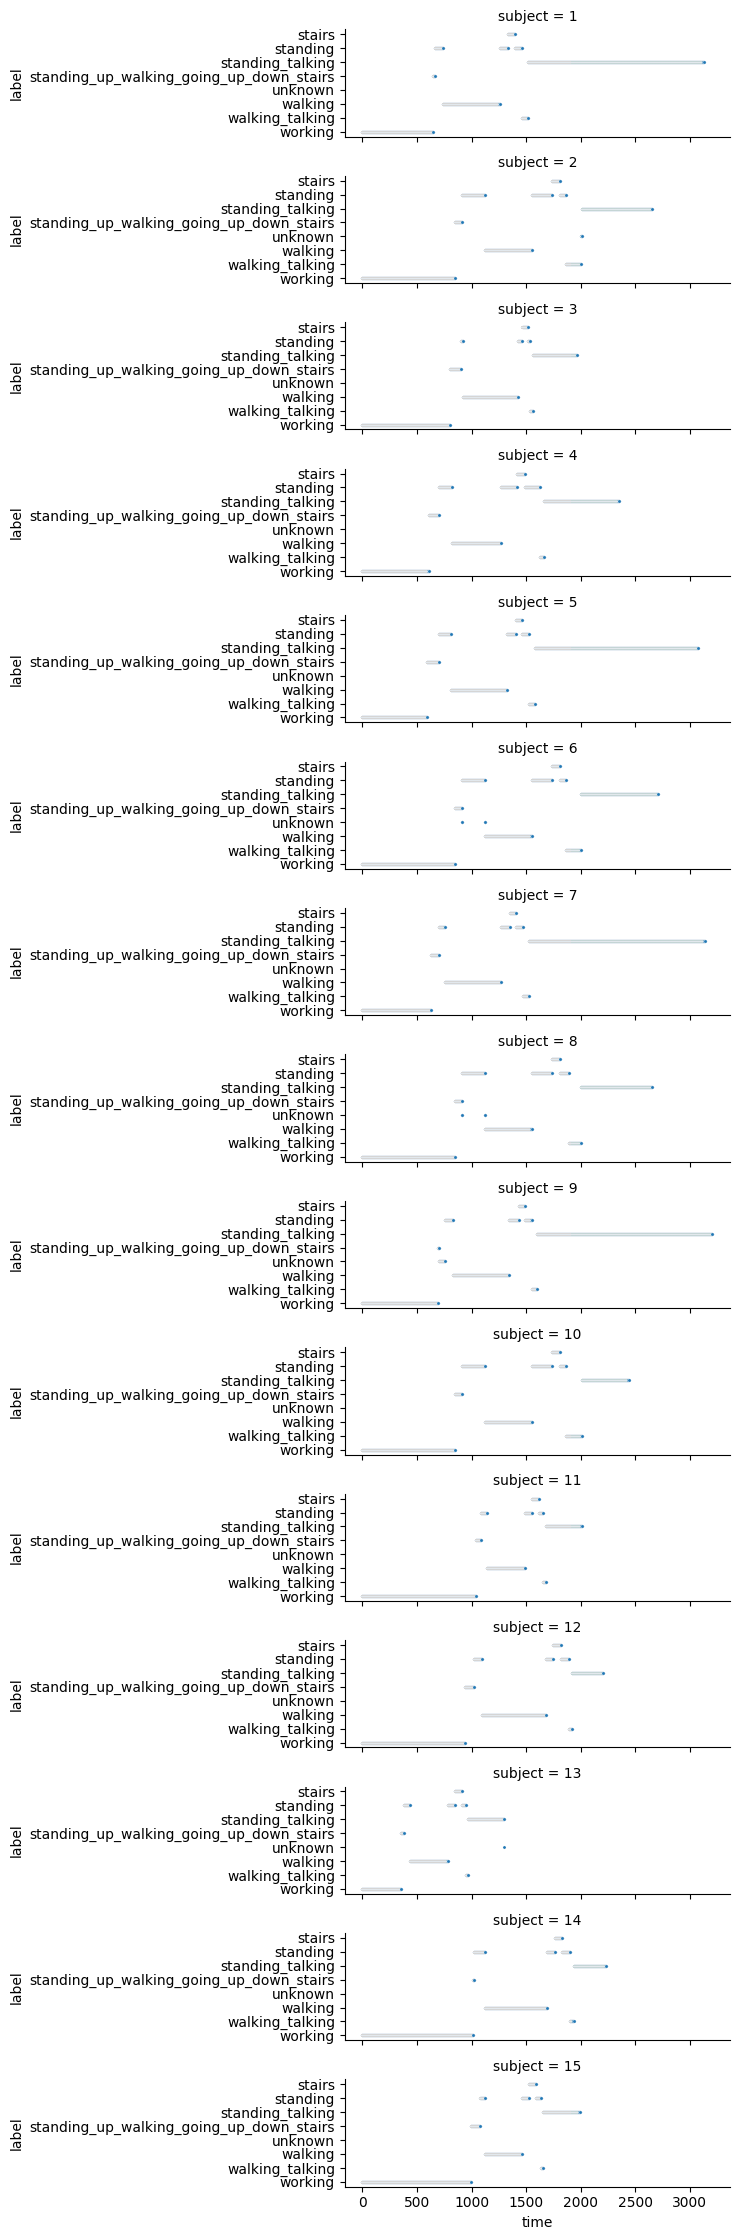

In [78]:

p = data.reset_index()
#p = p[p['time'] > 1.0]
seaborn.relplot(data=p, row='subject', y='label', x='time', height=1.5, aspect=5, s=5.0)




/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


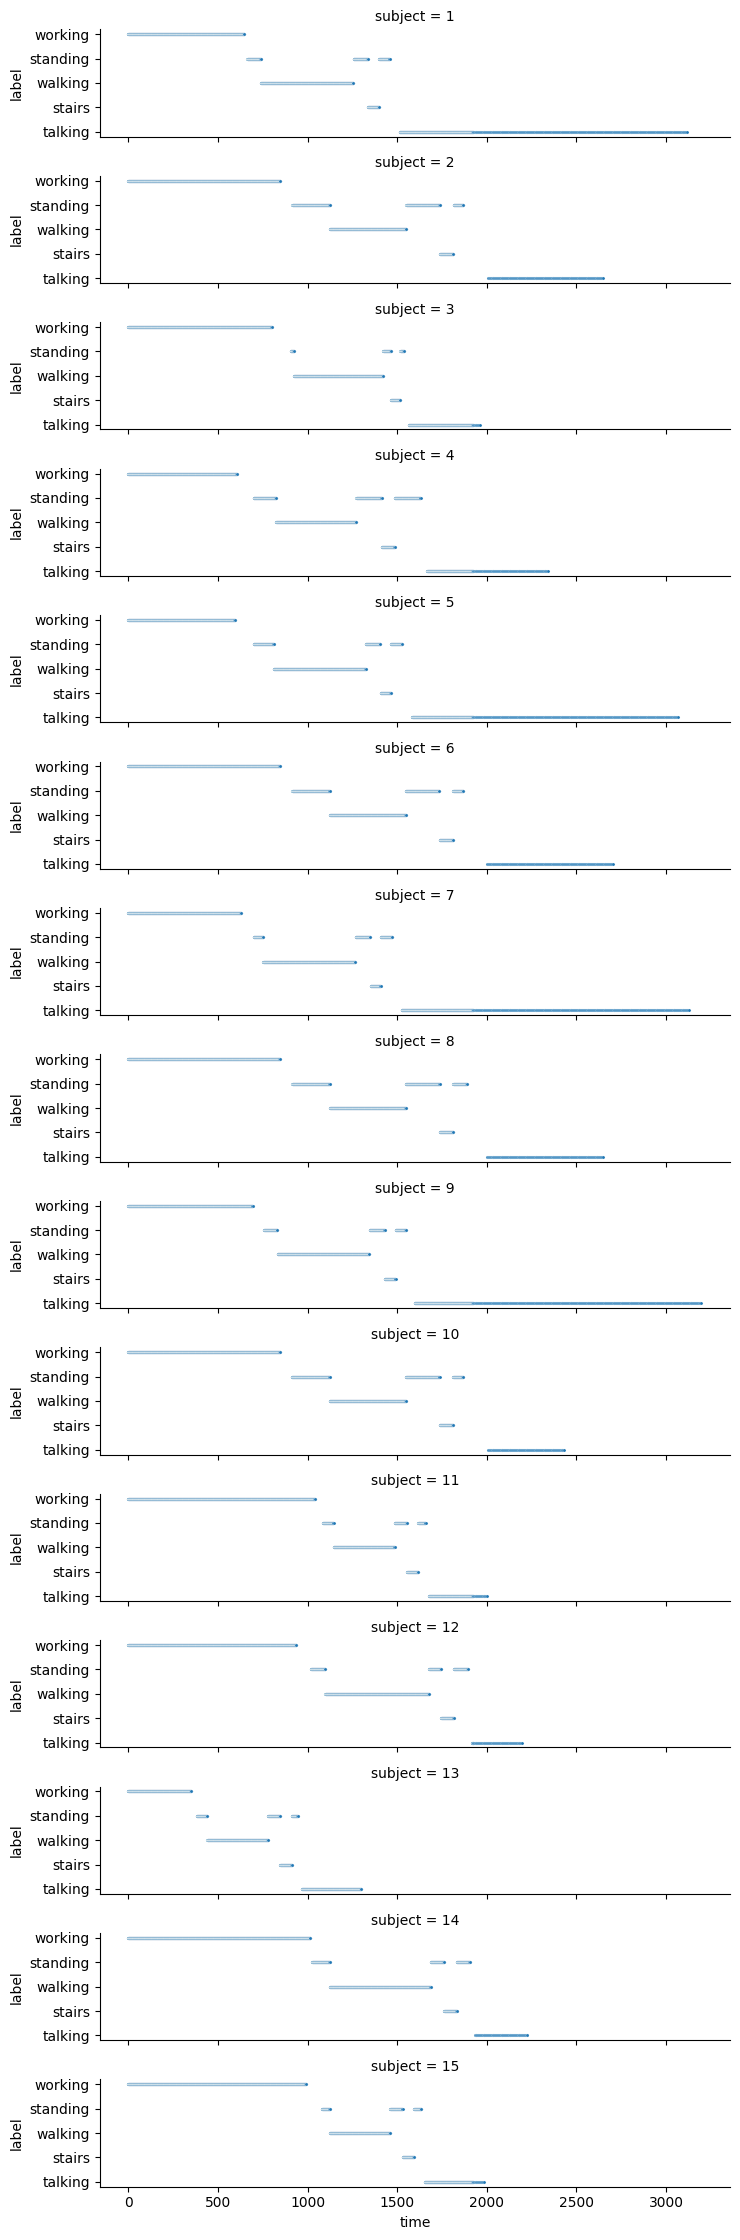

In [77]:

p = cleaned.reset_index()
#p = p[p['time'] > 1.0]
seaborn.relplot(data=p, row='subject', y='label', x='time', height=1.5, aspect=5, s=5.0)



In [71]:

# Setup evaluation
# 5-fold cross evaluation of instances

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=50, min_samples_leaf=0.001)

d = cleaned
feature_columns = list(set(d.columns) - set(['label']))
X = d[feature_columns]
Y = d['label']
cross_val_score(estimator, X, Y, cv=5, scoring='accuracy')



array([0.72135914, 0.77914055, 0.59276758, 0.51799019, 0.57514083])

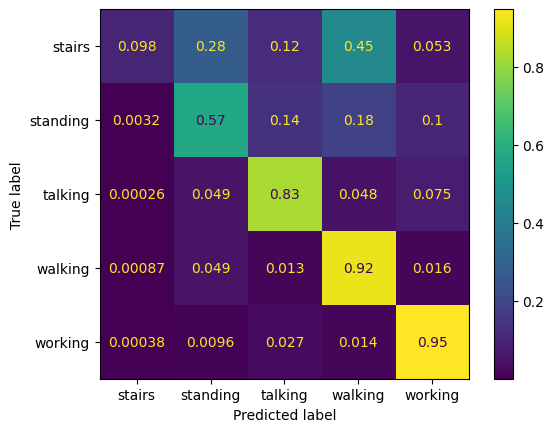

In [72]:
estimator.fit(X, Y)

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(estimator, X, Y, normalize='true')


In [ ]:
# TODO: setup evaluation respecting subject